<h2><center>IceBerg Detection</center></h2>

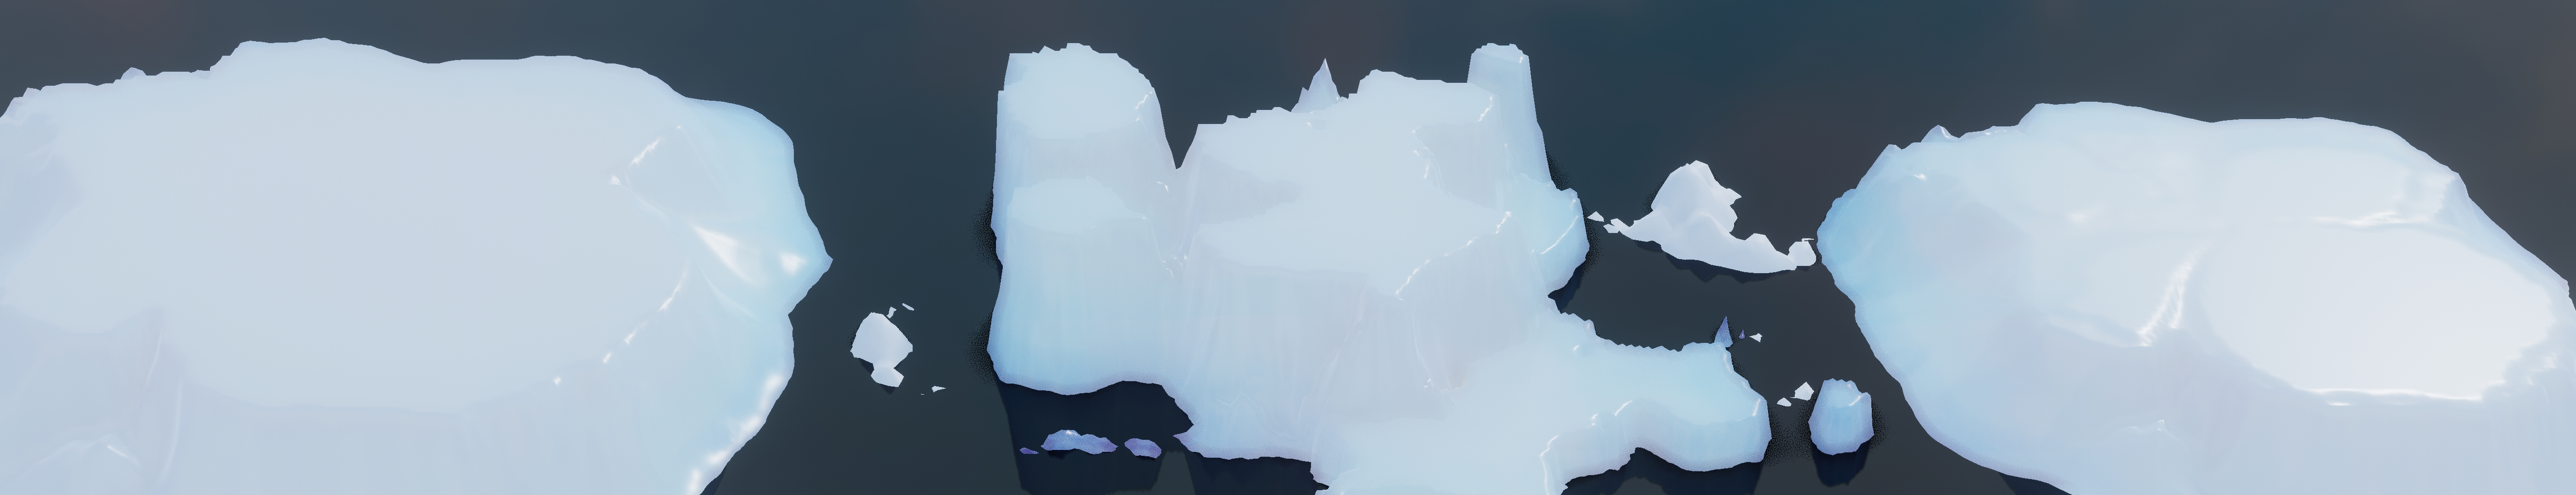

The code concerning ONNX was modified from https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html.

# Setup AIcrowd Utilities 🛠

In [ ]:
!pip install aicrowd-cli

%load_ext aicrowd.magic

## How to use this notebook? 📝

<p style="text-align: center"><img src="https://gitlab.aicrowd.com/aicrowd/assets/-/raw/master/notebook/aicrowd_notebook_submission_flow.png?inline=false" alt="notebook overview" style="width: 650px;"/></p>

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data (The data will be available at `/data/` on aridhia workspace). This should be an absolute path.
`AICROWD_OUTPUTS_PATH` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#Install-packages-🗃) section to install the packages
- **Training your models**. All the code within the [Training phase ⚙️](#Training-phase-⚙️) section will be skipped during evaluation. **Please make sure to save your model weights in the assets directory and load them in the predictions phase section** 

## AIcrowd Runtime Configuration 🧷

Define configuration parameters. Please include any files needed for the notebook to run under `ASSETS_DIR`. We will copy the contents of this directory to your final submission file 🙂

The dataset is available under `/data` on the workspace.

In [ ]:
import os

# Please use the absolute for the location of the dataset.
# Or you can use relative path with `os.getcwd() + "test_data/test.csv"`
AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/data/test")
AICROWD_OUTPUTS_PATH = os.getenv("OUTPUTS_DIR", "")
AICROWD_ASSETS_DIR = os.getenv("ASSETS_DIR", "assets")

# Install packages 🗃

Installing PyTorch & some other libraries

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch scikit-video natsort
!pip install onnx
!pip install onnxruntime

# Installing Scikit Video & FFMPEG
!pip install scikit-video
!pip install ffmpeg
!apt-get install ffmpeg gstreamer1.0-libav vlc
!apt-get update -qq && sudo apt-get -y install \
  autoconf \
  automake \
  build-essential \
  cmake \
  git-core \
  libass-dev \
  libfreetype6-dev \
  libgnutls28-dev \
  libsdl2-dev \
  libtool \
  libva-dev \
  libvdpau-dev \
  libvorbis-dev \
  libxcb1-dev \
  libxcb-shm0-dev \
  libxcb-xfixes0-dev \
  meson \
  ninja-build \
  pkg-config \
  texinfo \
  wget \
  yasm \
  zlib1g-dev
!apt-get install ffmpeg libsm6  libxext6 -y
!pip install sk-video p-tqdm
!apt-get update
!apt-get install -y python3-opencv
!pip install --upgrade opencv
!pip install --upgrade torch torchvision

# Define preprocessing code 💻

The code that is common between the training and the prediction sections should be defined here. During evaluation, we completely skip the training section. Please make sure to add any common logic between the training and prediction sections here.

In [ ]:
# Pytorch 
import onnx
import onnxruntime
import torch
import torch.onnx
from torch import nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

# Reading Dataset, vis and miscellaneous
from PIL import Image
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
from tqdm.notebook import tqdm
import cv2
from natsort import natsorted
from glob import glob
import skvideo.io

# Training phase ⚙️

You can define your training code here. This sections will be skipped during evaluation.

## Downloading Dataset

Hre we are downloading the challange dataset using AIcrowd CLI 

In [ ]:
%aicrowd login --api-key API_KEY

In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c iceberg-detection -o data

In [ ]:
# Unzipping the files
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

In [ ]:
import random

def seed_everything(seed):
  os.environ["PL_GLOBAL_SEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

seed_everything(1)

In [ ]:
indexes = [i for i in range(2000)]
val_idxes = random.sample(indexes, 60)
val_idxes[0]

In [ ]:
!rm -rf data/val
os.mkdir('data/val')
for idx in val_idxes:
  shutil.move(f'data/train/image_{idx}.mp4', 'data/val')
  shutil.move(f'data/train/segmentation_{idx}.mp4', 'data/val')

### Dataloader

In [ ]:
from torchvision import transforms

class IcebergsSegmentationDataset(Dataset):
    
    def __init__(self, data_directory=None):
        

        self.data_directory = data_directory          

        # If the image direcotry is valid      
        if data_directory != None:
          self.image_videos_files = natsorted(glob(data_directory+"/image*"))
          self.segmentation_videos_files = natsorted(glob(data_directory+"/segmentation*"))

        self.img_list = list(zip(self.image_videos_files, self.segmentation_videos_files))
        self.mutual_transfroms = mutual_transforms
        
    def __len__(self):
        return len(self.img_list) * 23

    def __getitem__(self, idx):

      img_video = cv2.VideoCapture(self.img_list[idx//23][0]) 
      img_video.set(1, idx%23)
      ret, img = img_video.read()
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Reading the segmentation video
      seg_video = cv2.VideoCapture(self.img_list[idx//23][1])
      seg_video.set(1, idx%23)
      ret, mask = seg_video.read()
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

      # Resizing the images
      img = cv2.resize(img, (256, 256))
      mask = cv2.resize(mask, (256, 256))

      img = transforms.ToTensor()(img)

      _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
      mask = transforms.ToTensor()(mask)

      return img, mask

In [ ]:
# Creating the training dataset
train_dataset = IcebergsSegmentationDataset(data_directory="data/train")
train_loader = DataLoader(train_dataset, batch_size=23, shuffle=True, drop_last=True)
val_dataset = IcebergsSegmentationDataset(data_directory="data/val")
val_loader = DataLoader(val_dataset, batch_size=23, shuffle=True, drop_last=True)

In [ ]:
# Reading the image and corrosponding segmentation
image_batch, segmentation_batch = next(iter(train_loader))

image_batch.shape, segmentation_batch.shape

## Visualizing Dataset

In [ ]:
plt.rcParams["figure.figsize"] = (30,5)

# Going through each image and segmentation
for image, segmentation in zip(image_batch, segmentation_batch):

  # Showing the image
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(image[0], 'gray', interpolation='none')
  plt.subplot(1,2,2)
  plt.imshow(image[0], 'gray', interpolation='none')
  plt.imshow(segmentation[0], 'jet', interpolation='none', alpha=0.7)
  plt.show()

## Creating the Model

Here we will get setting up the model architecture, optimizer and loss.

In [ ]:
model = smp.Unet(
    encoder_name='resnet18', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
    in_channels=1
)

In [ ]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0002),
])

## Training the Model

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0
# counter = 0
# early_stopping = 5

for i in range(0, 4): 
  print('\nEpoch: {}'.format(i))
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(val_loader)
  curr_score = valid_logs['fscore']
  
  if max_score < curr_score:
    # counter = 0
    max_score = curr_score
    torch.save(model, 'best.pth')
    print('Model saved!')
  # else:
  #   counter += 1
  torch.save(model, 'last.pth')

  # if counter == early_stopping:
  #   print("Early stopping")
  #   break

In [ ]:
model = torch.load('best.pth')

In [ ]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0002),
])

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0
# counter = 0
# early_stopping = 5

for i in range(0, 15): 
  print('\nEpoch: {}'.format(i))
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(val_loader)
  curr_score = valid_logs['fscore']
  
  if max_score < curr_score:
    # counter = 0
    max_score = curr_score
    torch.save(model, 'best.pth')
    print('Model saved!')
  # else:
  #   counter += 1
  torch.save(model, 'last.pth')

  # if counter == early_stopping:
  #   print("Early stopping")
  #   break

In [ ]:
model = torch.load('best.pth', map_location='cpu')

## Visualize Predictions

In [ ]:
predictions = model.predict(image_batch)
predictions.shape

In [ ]:
# Going through each image and segmentation
for image, segmentation in zip(image_batch, predictions.cpu()):

  # Showing the image
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(image[0], 'gray', interpolation='none')
  plt.subplot(1,2,2)
  plt.imshow(image[0], 'gray', interpolation='none')
  plt.imshow(segmentation[0], 'jet', interpolation='none', alpha=0.7)
  plt.show()

## Saving the Model

In [ ]:
!rm -rf assets
!mkdir assets
batch_size = 1
x = torch.randn(batch_size, 1, 256, 256, requires_grad=True)
torch_out = model(x)

# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "assets/segmentation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

# Prediction phase 🔎

Generating the features in test dataset. 

## Loading the Model

In [ ]:
def process_img(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (256, 256)) / 255
  return img[np.newaxis, :]

def get_imgs(video_file):
  img_video = cv2.VideoCapture(video_file)
  img_video.set(1, 0)
  imgs = []
  ret, img = img_video.read()
  while ret:
    imgs.append(img)
    ret, img = img_video.read()
  img_video.release()
  imgs = [process_img(img) for img in imgs]
  return np.stack(imgs)

In [ ]:
import onnxruntime as ort

# Generating Predictions Function
def gen_predictions(AICROWD_OUTPUTS_PATH):
  ort_session = ort.InferenceSession('assets/segmentation.onnx')
  data_directory=AICROWD_DATASET_PATH
  video_files = natsorted(glob(os.path.join(data_directory, "image")+"*"))
  for batch_idx, video_file in tqdm(enumerate(video_files)):
    image_batch = get_imgs(video_file)
    predictions = ort_session.run(None, {'input': image_batch.astype(np.float32)})[0]

    writer = skvideo.io.FFmpegWriter(os.path.join(AICROWD_OUTPUTS_PATH,  f"segmentation_{batch_idx}.mp4"), outputdict={
                '-vcodec': 'libx264',  
                '-crf': '0',           
                '-preset':'veryslow'   
                })

    for seg in predictions:
      seg_np = seg[0] * 255
      # Resizing the video
      seg_np = cv2.resize(seg_np, (512, 512))

      _, seg_np = cv2.threshold(seg_np, 127, 255, cv2.THRESH_BINARY)
      writer.writeFrame(seg_np.astype(np.uint8))

    writer.close()

## Generating the Predictions

In [ ]:
gen_predictions(AICROWD_OUTPUTS_PATH)

# Submit to AIcrowd 🚀¶